[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train YOLO11 Instance Segmentation on a Custom Dataset

---

[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/ultralytics/ultralytics)

YOLO11 builds on the advancements introduced in YOLOv9 and YOLOv10 earlier this year, incorporating improved architectural designs, enhanced feature extraction techniques, and optimized training methods.

YOLO11m achieves a higher mean mAP score on the COCO dataset while using 22% fewer parameters than YOLOv8m, making it computationally lighter without sacrificing performance.

YOLOv11 is available in 5 different sizes, ranging from `2.6M` to `56.9M` parameters, and capable of achieving from `39.5` to `54.7` mAP on the COCO dataset.

## Setup

### Configure API keys

To fine-tune YOLO11, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

### Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [30]:
import time

# Catat waktu mulai
start_time = time.time()

In [31]:
!nvidia-smi

Wed Oct  8 08:32:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [32]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLO11 via Ultralytics

In [36]:
%pip install ultralytics supervision roboflow
# prevent ultralytics from tracking your activity
!yolo settings sync=False
import ultralytics
ultralytics.checks()

Ultralytics 8.3.206 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 40.1/112.6 GB disk)


## Fine-tune YOLO11 on custom dataset

**NOTE:** When training YOLOv11, make sure your data is located in `datasets`. If you'd like to change the default location of the data you want to use for fine-tuning, you can do so through Ultralytics' `settings.json`. In this tutorial, we will use one of the [datasets](https://universe.roboflow.com/ks-fsm9o/pelvis-ap-x-ray) available on [Roboflow Universe](https://universe.roboflow.com/). When downloading, make sure to select the `yolov11` export format.

In [37]:
from roboflow import Roboflow

!roboflow workspace list

In [38]:
!mkdir -p {HOME}/datasets
%cd {HOME}/datasets

from roboflow import Roboflow

# --- IMPORTANT: SET YOUR ROBOFLOW CREDENTIALS ---
# Option 1
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("ROBOFLOW_API_KEY")
VERSION = 24 # Dataset version in roboflow

# Option 2: Paste your API key directly (less secure).
# ROBOFLOW_API_KEY = "YOUR_ROBOFLOW_API_KEY" # <-- PASTE YOUR KEY HERE

if ROBOFLOW_API_KEY == "YOUR_ROBOFLOW_API_KEY":
    print("ERROR: Please replace 'YOUR_ROBOFLOW_API_KEY' with your actual Roboflow API key.")
else:
    rf = Roboflow(api_key=ROBOFLOW_API_KEY)
    workspace = rf.workspace("tbe") # Your workspace ID
    project = workspace.project("rice-grain-svjri") # Your project ID
    version = project.version(VERSION)
    dataset = version.download("yolov11")

/content/datasets
loading Roboflow workspace...
loading Roboflow project...


# Bulir Padi Segmentation: Advanced Augmentation Pipeline

This notebook extends the original Roboflow data loading and copy-paste augmentation with a more advanced, offline augmentation pipeline. The key additions are:

1.  **Conditional Tiling**: High-resolution images are tiled to handle large inputs effectively.
2.  **Randomized Augmentations**: A variety of geometric, color, and structural augmentations are applied randomly to increase dataset variance.
3.  **Dataset Expansion**: The training set is expanded by a configurable factor (e.g., 5x).
4.  **Detailed Logging**: The process generates a summary of augmentations and class distributions.

The original copy-paste logic for class balancing is preserved and will run *after* this new pipeline has expanded the dataset.

## Section 1: Pre-Augmentation Setup & Utilities

This section contains all the necessary imports, configurations, and helper functions for the new augmentation pipeline.

In [39]:
# Install library for augmentation
%pip install albumentations opencv-python-headless scikit-image

In [40]:
# New Imports for Tiling, Augmentation, and Logging
import cv2
import numpy as np
import albumentations as A
from pathlib import Path
import shutil
from tqdm.notebook import tqdm
import yaml
from collections import Counter, defaultdict
import random
import json
import pandas as pd
from skimage.measure import find_contours

# --- Configuration for New Augmentation Pipeline ---
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# 1. Preprocessing - Conditional Tiling
TILING_THRESHOLD = 1500  # Tile images with width or height > 1500px
TILE_SIZE = (1024, 1024)   # Size of each tile
TILE_OVERLAP = 0.1       # 10% overlap between tiles

# 2. Dataset Expansion
EXPANSION_FACTOR = 5  # Target: 5x the original dataset size

# 3. Randomized Augmentation Logic
NUM_AUGMENTATIONS_MIN = 3 # Min number of augmentations to apply per image
NUM_AUGMENTATIONS_MAX = 5 # Max number of augmentations to apply per image

print("Configuration for Tiling and Augmentation pipeline is set.")

Configuration for Tiling and Augmentation pipeline is set.


In [41]:
# --- Helper Functions for Mask and Annotation Conversion ---

def yolo_to_masks(annotation_path, img_height, img_width):
    """Reads YOLO segmentation format and converts it to a list of binary masks."""
    masks = []
    class_ids = []
    if not Path(annotation_path).exists():
        return masks, class_ids

    with open(annotation_path, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split()
            if len(parts) > 1:
                class_id = int(parts[0])
                poly = np.array(parts[1:], dtype=np.float32).reshape(-1, 2)
                poly[:, 0] *= img_width
                poly[:, 1] *= img_height
                poly = poly.astype(np.int32)

                mask = np.zeros((img_height, img_width), dtype=np.uint8)
                cv2.fillPoly(mask, [poly], 1)
                masks.append(mask)
                class_ids.append(class_id)
    return masks, class_ids

def masks_to_yolo(masks, class_ids, img_height, img_width):
    """Converts a list of binary masks back to YOLO segmentation format."""
    annotations = []
    for i, mask in enumerate(masks):
        if np.sum(mask) == 0:
            continue
        # Pad mask to avoid issues at edges
        padded_mask = np.pad(mask, pad_width=1, mode='constant', constant_values=0)
        contours = find_contours(padded_mask, 0.5)

        if not contours:
            continue
        # Use the largest contour
        contour = max(contours, key=len)
        # Revert padding effect
        contour -= 1

        # YOLO format requires x, y coordinates
        # find_contours returns y, x, so we flip them
        contour = np.flip(contour, axis=1)

        if len(contour) < 3:
            continue

        # Normalize
        contour = contour.astype(np.float32)
        contour[:, 0] /= img_width
        contour[:, 1] /= img_height

        contour = np.clip(contour, 0.0, 1.0)

        yolo_coords = ' '.join([f'{coord:.6f}' for coord in contour.flatten()])
        annotations.append(f"{int(class_ids[i])} {yolo_coords}")
    return annotations

print("Mask and YOLO annotation conversion utilities are defined.")

Mask and YOLO annotation conversion utilities are defined.


In [42]:
# --- Core Preprocessing and Augmentation Functions ---

def tile_if_highres(image, masks):
    """Performs tiling only on high-resolution images."""
    height, width = image.shape[:2]
    if width <= TILING_THRESHOLD and height <= TILING_THRESHOLD:
        return [(image, masks)], False  # Return original as a single-item list

    tiled_data = []
    tile_w, tile_h = TILE_SIZE
    step_w = int(tile_w * (1 - TILE_OVERLAP))
    step_h = int(tile_h * (1 - TILE_OVERLAP))

    for y in range(0, height, step_h):
        for x in range(0, width, step_w):
            x1, y1 = x, y
            x2, y2 = min(x + tile_w, width), min(y + tile_h, height)

            # Skip tiles that are too small
            if (x2 - x1) < tile_w / 2 or (y2 - y1) < tile_h / 2:
                continue

            tile_img = image[y1:y2, x1:x2]
            tile_masks = [m[y1:y2, x1:x2] for m in masks]

            # Only keep tiles that contain at least part of an object
            if any(np.sum(m) > 0 for m in tile_masks):
                tiled_data.append((tile_img, tile_masks))

    return tiled_data, True

def get_augmentation_pipelines():
    """Defines augmentation pipelines in the order: geometric → affine → structural → color → noise_blur"""

    pipelines = {
        # Step 1: Geometric
        'geometric': A.Compose([
            A.HorizontalFlip(p=1.0),
            A.VerticalFlip(p=1.0),
            A.RandomRotate90(p=1.0)
        ], p=1.0, seed=SEED),

        # Step 2: Affine / Perspective
        'affine': A.Compose([
            A.ShiftScaleRotate(
                shift_limit=0.15, scale_limit=0.2, rotate_limit=20, p=1.0
            ),
            A.Affine(shear=(-10, 10), p=1.0),
            A.Perspective(scale=(0.05, 0.15), keep_size=True, p=1.0)
        ], p=1.0, seed=SEED),

        # Step 3: Dropout / occlusion
        'structural': A.Compose([
            A.CoarseDropout(
                num_holes_range=(1, 8),
                hole_height_range=(0.02, 0.1),
                hole_width_range=(0.02, 0.1),
                fill=0,
                fill_mask=None,
                p=1.0
            ),
            A.GridDistortion(p=1.0),
        ], p=1.0, seed=SEED),

        # Step 4: Color
        'color': A.Compose([
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1.0),
            A.HueSaturationValue(hue_shift_limit=0, sat_shift_limit=30, val_shift_limit=20, p=1.0),
            A.RGBShift(r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, p=1.0),
        ], p=1.0, seed=SEED),

        # Step 5: Noise / Blur
        'noise_blur': A.Compose([
            A.GaussNoise(std_range=(0.04, 0.2), mean_range=(0.0, 0.0), per_channel=True, noise_scale_factor=1.0, p=1.0),
            A.GaussianBlur(blur_limit=(3, 7), p=1.0),
            A.ISONoise(p=1.0)
        ], p=1.0, seed=SEED),
    }

    return pipelines

def apply_random_augmentations(image, masks, pipelines):
    """
    Applies resizing/cropping first, then randomly selects 3-5 categories from the step_order.
    For each selected category, only one transform from that category is applied.
    """
    # --- Cropping already applied during preprocessing ---
    cropped = {'image': image, 'masks': masks}
    augmented_image = cropped['image']
    augmented_masks = cropped['masks']

    # Step order
    step_order = ['geometric', 'affine', 'structural', 'color', 'noise_blur']

    # Randomly pick 3-5 categories
    num_to_apply = random.randint(NUM_AUGMENTATIONS_MIN, NUM_AUGMENTATIONS_MAX)
    chosen_categories = random.sample(step_order, num_to_apply)

    applied_augs = []

    # Apply each chosen category in step_order
    for category in step_order:
        if category in chosen_categories:
            transforms = pipelines[category].transforms
            if transforms:
                # Randomly pick ONE transform from the category
                transform_to_apply = random.choice(transforms)
                temp_pipeline = A.Compose([transform_to_apply])
                transformed = temp_pipeline(image=augmented_image, masks=augmented_masks)
                augmented_image = transformed['image']
                augmented_masks = transformed['masks']
                applied_augs.append(transform_to_apply.__class__.__name__)

    return augmented_image, augmented_masks, applied_augs

print("Core preprocessing and augmentation functions are defined.")

Core preprocessing and augmentation functions are defined.


In [43]:
# --- Logging and Summary Function ---

def log_augmentation_stats(stats, output_dir):
    """Generates and saves a summary of the augmentation process."""
    output_dir = Path(output_dir)
    summary = {}

    # 1. Dataset Size
    summary['Dataset Size'] = {
        'Before': stats['initial_image_count'],
        'After': stats['final_image_count']
    }

    # 2. Per-class Counts
    class_names = stats['class_names']
    summary['Class Counts Before'] = {class_names[i]: count for i, count in stats['initial_class_counts'].items()}
    summary['Class Counts After'] = {class_names[i]: count for i, count in stats['final_class_counts'].items()}

    # 3. Augmentation Frequency
    total_augs = sum(stats['augmentation_freq'].values())
    summary['Augmentation Frequency'] = {
        aug: {
            'Count': count,
            'Percentage': f"{(count / total_augs * 100):.2f}%" if total_augs > 0 else "0.00%"
        } for aug, count in sorted(stats['augmentation_freq'].items())
    }
    summary['Tiling Info'] = {
        'Images Tiled': stats['tiling_info']['images_tiled'],
        'Total Tiles Generated': stats['tiling_info']['tiles_generated']
    }

    # --- Print Summary Table ---
    print("\n--- Augmentation Summary ---")
    print(f"Dataset Size: {summary['Dataset Size']['Before']} -> {summary['Dataset Size']['After']}")

    df_classes = pd.DataFrame([
        summary['Class Counts Before'],
        summary['Class Counts After']
    ], index=['Before', 'After']).T
    print("\nClass Distribution:")
    print(df_classes.to_string())

    df_augs = pd.DataFrame.from_dict(summary['Augmentation Frequency'], orient='index')
    print("\nAugmentation Frequency:")
    print(df_augs.to_string())

    print(f"\nImages Tiled: {summary['Tiling Info']['Images Tiled']}")
    print(f"Total Tiles Generated: {summary['Tiling Info']['Total Tiles Generated']}")

    # --- Save to CSV ---
    csv_path = output_dir / 'augmentation_summary.csv'
    try:
        df_summary = pd.concat([df_classes.T, df_augs.T]).T
        df_summary.to_csv(csv_path)
        print(f"\nSummary saved to {csv_path}")
    except Exception as e:
        print(f"\nCould not save summary CSV: {e}")

    return summary

print("Logging and summary function is defined.")

Logging and summary function is defined.


In [ ]:
def visualize_image_with_polygons(image, masks, title=None):
    """Draw polygons (masks) over an image for visualization."""
    vis_img = image.copy()
    for mask in masks:
        # Convert mask to contour for visualization
        contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(vis_img, contours, -1, (0, 255, 0), 2)  # green polygon outline
    if title:
        plt.title(title)
    plt.imshow(vis_img)
    plt.axis('off')
    return vis_img


def show_comparison(before_img, before_masks, after_img, after_masks, title_before="Before", title_after="After"):
    """Show side-by-side before/after visualization."""
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    visualize_image_with_polygons(before_img, before_masks, title=title_before)

    plt.subplot(1, 2, 2)
    visualize_image_with_polygons(after_img, after_masks, title=title_after)

    plt.tight_layout()
    plt.show()

## Section 2: Main Augmentation Pipeline Execution

This is the main execution block. It performs the following steps:
1.  Backs up the original training data.
2.  Calculates the target number of images for expansion.
3.  Iterates through the original dataset, applying tiling and random augmentations.
4.  Saves the newly generated images, masks, and metadata to a temporary directory.
5.  Overwrites the original training data with the augmented data.
6.  Logs the final statistics.

**Note:** This process will modify your dataset in place. The backup is created in `train_original_backup`.

In [44]:
# Define dataset paths from Roboflow download
if 'dataset' in globals():
    DATASET_PATH = Path(dataset.location).resolve()
else:
    # Fallback if the Roboflow cell was skipped
    DATASET_PATH = Path(f"{HOME}/datasets/Rice-Grain-svjri-{VERSION}").resolve()
    print(f"WARNING: Roboflow 'dataset' object not found. Using fallback path: {DATASET_PATH}")

DATA_CONFIG_PATH = DATASET_PATH / "data.yaml"
if not DATA_CONFIG_PATH.exists():
    raise FileNotFoundError(f"data.yaml not found at {DATA_CONFIG_PATH}. Please ensure the dataset was downloaded correctly.")

# Load data config
with open(DATA_CONFIG_PATH, 'r') as f:
    data_config = yaml.safe_load(f)
CLASS_NAMES = data_config['names']

TRAIN_IMAGES_PATH = DATASET_PATH / data_config['train'].replace("../", "")
TRAIN_LABELS_PATH = TRAIN_IMAGES_PATH.parent / 'labels'

# --- DUPLICATE IMAGE CLEANUP (Based on annotation count) ---
print("\n🔍 Checking for duplicate images (same name, different format or copy)...")

# Gather all image files
all_images = list(TRAIN_IMAGES_PATH.glob('*.jpg')) + list(TRAIN_IMAGES_PATH.glob('*.png'))
name_to_files = defaultdict(list)
for img_path in all_images:
    name_to_files[img_path.stem].append(img_path)

duplicate_count = 0

for name, paths in name_to_files.items():
    if len(paths) > 1:
        # Count annotations for each image’s label file
        ann_counts = []
        for p in paths:
            label_path = TRAIN_LABELS_PATH / f"{p.stem}.txt"
            if label_path.exists():
                with open(label_path, 'r') as f:
                    ann_counts.append((p, label_path, len(f.readlines())))
            else:
                # no label → 0 annotations
                ann_counts.append((p, label_path, 0))

        # Sort by number of annotations (descending)
        ann_counts.sort(key=lambda x: x[2], reverse=True)
        keep_img, keep_label, keep_count = ann_counts[0]

        # Delete duplicates with fewer annotations
        for img_path, lbl_path, count in ann_counts[1:]:
            try:
                if img_path.exists():
                    img_path.unlink()
                if lbl_path.exists():
                    lbl_path.unlink()
                duplicate_count += 1
                print(f"🗑️ Deleted duplicate {img_path.name} ({count} anns) — kept {keep_img.name} ({keep_count} anns)")
            except Exception as e:
                print(f"⚠️ Failed to delete duplicate {img_path.name}: {e}")

print(f"\n✅ Duplicate cleanup done. {duplicate_count} images (and matching labels) removed.")

print(f"Dataset Location: {DATASET_PATH}")
print(f"Train Images Path: {TRAIN_IMAGES_PATH}")
print(f"Train Labels Path: {TRAIN_LABELS_PATH}")
print(f"Class Names: {CLASS_NAMES}")

Dataset Location: /content/datasets/Rice-Grain-21
Train Images Path: /content/datasets/Rice-Grain-21/train/images
Train Labels Path: /content/datasets/Rice-Grain-21/train/labels
Class Names: ['brown_spot', 'bulir_sehat']


In [45]:
# --- Main Execution Block (Revised Logic) ---
print("Starting the advanced augmentation and dataset expansion process...")

# 1. Backup original data
original_images_path = TRAIN_IMAGES_PATH
original_labels_path = TRAIN_LABELS_PATH
backup_images_path = DATASET_PATH / 'train_original_backup' / 'images'
backup_labels_path = DATASET_PATH / 'train_original_backup' / 'labels'

if not backup_images_path.exists() and original_images_path.exists():
    print("Backing up original training data...")
    shutil.copytree(original_images_path, backup_images_path)
    shutil.copytree(original_labels_path, backup_labels_path)
    print(f"Backup complete in {DATASET_PATH / 'train_original_backup'}")
else:
    print("Backup already exists or source is missing. Using existing backup as source.")
    original_images_path = backup_images_path
    original_labels_path = backup_labels_path

# Initialize stats and pipelines
stats = {
    'initial_image_count': 0, # Will be calculated after tiling
    'final_image_count': 0,
    'class_names': CLASS_NAMES,
    'initial_class_counts': Counter(),
    'final_class_counts': Counter(),
    'augmentation_freq': Counter(),
    'tiling_info': {'images_tiled': 0, 'tiles_generated': 0}
}
pipelines = get_augmentation_pipelines()

# --- STAGE 1: TILING & PRE-PROCESSING ---
# Create a temporary directory for the pre-processed (tiled) dataset
preprocessed_images_path = DATASET_PATH / 'train_preprocessed_temp' / 'images'
preprocessed_labels_path = DATASET_PATH / 'train_preprocessed_temp' / 'labels'
shutil.rmtree(preprocessed_images_path.parent, ignore_errors=True)
preprocessed_images_path.mkdir(parents=True, exist_ok=True)
preprocessed_labels_path.mkdir(parents=True, exist_ok=True)

original_image_files = sorted(list(original_images_path.glob('*.jpg')) + list(original_images_path.glob('*.png')))

print("Stage 1: Pre-processing images (tiling if high-res)...")
for img_path in tqdm(original_image_files, desc="Preprocessing"):
    label_path = original_labels_path / f"{img_path.stem}.txt"
    if not label_path.exists(): continue

    image = cv2.imread(str(img_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width = image.shape[:2]
    masks, class_ids = yolo_to_masks(label_path, height, width)

    tiled_data, was_tiled = tile_if_highres(image, masks)
    if was_tiled:
        stats['tiling_info']['images_tiled'] += 1
        stats['tiling_info']['tiles_generated'] += len(tiled_data)

    # Save the results (either tiles or the original low-res image)
    for i, (tile_img, tile_masks) in enumerate(tiled_data):
        new_stem = f"{img_path.stem}"
        if was_tiled: new_stem += f"_tile_{i}"

        # Resizing / Cropping (always applied first, not counted in random selection)
        resize = {
            'cropping': A.Compose([
                A.LongestMaxSize(max_size=TILE_SIZE[0], p=1.0),
                A.PadIfNeeded(min_height=TILE_SIZE[0], min_width=TILE_SIZE[1], fill=0, p=1.0),
            ], p=1.0, seed=SEED),
        }
        
        # --- 🔹 Apply resizing/padding (cropping pipeline) here ---
        cropped = resize['cropping'](image=tile_img, masks=tile_masks)
        cropped_img = cropped['image']
        cropped_masks = cropped['masks']

        if random.random() < 0.02:  # visualize ~2% of images
            show_comparison(
                image, masks,
                cropped_img, cropped_masks,
                title_before=f"Before tiling ({img_path.name})",
                title_after="After tiling & resizing"
            )

        new_img_path = preprocessed_images_path / f"{new_stem}.jpg"
        new_label_path = preprocessed_labels_path / f"{new_stem}.txt"

        cropped_height, cropped_width = cropped_img.shape[:2]
        yolo_annotations = masks_to_yolo(cropped_masks, class_ids, cropped_height, cropped_width)

        if yolo_annotations:
            cv2.imwrite(str(new_img_path), cv2.cvtColor(cropped_img, cv2.COLOR_RGB2BGR))
            with open(new_label_path, 'w') as f:
                f.write('\n'.join(yolo_annotations))

# --- STAGE 2: AUGMENTATION & EXPANSION ---
print("\nStage 2: Expanding dataset with random augmentations...")
preprocessed_files = sorted(list(preprocessed_images_path.glob('*.jpg')))
initial_image_count = len(preprocessed_files)
target_image_count = initial_image_count * EXPANSION_FACTOR
stats['initial_image_count'] = initial_image_count

# Prepare final temp directory
temp_aug_images_path = DATASET_PATH / 'train_augmented_temp' / 'images'
temp_aug_labels_path = DATASET_PATH / 'train_augmented_temp' / 'labels'
shutil.rmtree(temp_aug_images_path.parent, ignore_errors=True)
temp_aug_images_path.mkdir(parents=True, exist_ok=True)
temp_aug_labels_path.mkdir(parents=True, exist_ok=True)

# Copy pre-processed files and gather initial stats
for img_path in preprocessed_files:
    label_path = preprocessed_labels_path / f"{img_path.stem}.txt"
    if not label_path.exists(): continue
    with open(label_path, 'r') as f:
        for line in f.readlines():
            stats['initial_class_counts'][int(line.split()[0])] += 1
    shutil.copy(img_path, temp_aug_images_path)
    shutil.copy(label_path, temp_aug_labels_path)

generated_count = initial_image_count
pbar = tqdm(total=target_image_count, initial=generated_count, desc="Augmenting Data")

# Augmentation loop
while generated_count < target_image_count:
    img_path = random.choice(preprocessed_files)
    label_path = preprocessed_labels_path / f"{img_path.stem}.txt"

    image = cv2.imread(str(img_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width = image.shape[:2]

    masks, class_ids = yolo_to_masks(label_path, height, width)
    if not masks: continue

    # Apply augmentations (no tiling needed here)
    aug_img, aug_masks, applied_augs = apply_random_augmentations(image, masks, pipelines)
    for aug_name in applied_augs: stats['augmentation_freq'][aug_name] += 1

    # Visualize a few augmentations
    if random.random() < 0.02:  # visualize ~2% of augmented samples
        show_comparison(
            image, masks,
            aug_img, aug_masks,
            title_before=f"Original ({img_path.name})",
            title_after=f"Augmented ({', '.join(applied_augs)})"
        )

    # Save augmented data
    new_stem = f"{img_path.stem}_aug_{generated_count}"
    new_img_path = temp_aug_images_path / f"{new_stem}.jpg"
    new_label_path = temp_aug_labels_path / f"{new_stem}.txt"
    new_meta_path = temp_aug_labels_path / f"{new_stem}.json"

    aug_height, aug_width = aug_img.shape[:2]
    yolo_annotations = masks_to_yolo(aug_masks, class_ids, aug_height, aug_width)

    if yolo_annotations:
        cv2.imwrite(str(new_img_path), cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR))
        with open(new_label_path, 'w') as f: f.write('\n'.join(yolo_annotations))
        metadata = {
            'original_image': img_path.name,
            'applied_augmentations': applied_augs
        }
        with open(new_meta_path, 'w') as f: json.dump(metadata, f, indent=4)
        generated_count += 1
        pbar.update(1)

pbar.close()
shutil.rmtree(preprocessed_images_path.parent) # Clean up pre-processed folder

# --- STAGE 3: FINALIZATION ---
print("\nStage 3: Replacing original data and logging stats...")
shutil.rmtree(TRAIN_IMAGES_PATH)
shutil.rmtree(TRAIN_LABELS_PATH)
shutil.move(str(temp_aug_images_path), str(TRAIN_IMAGES_PATH))
shutil.move(str(temp_aug_labels_path), str(TRAIN_LABELS_PATH))
shutil.rmtree(temp_aug_images_path.parent)
print("Dataset overwrite complete.")

final_image_files = list(TRAIN_IMAGES_PATH.glob('*.jpg'))
stats['final_image_count'] = len(final_image_files)
for label_file in TRAIN_LABELS_PATH.glob('*.txt'):
    with open(label_file, 'r') as f:
        for line in f.readlines():
            stats['final_class_counts'][int(line.split()[0])] += 1

log_augmentation_stats(stats, DATASET_PATH)

Starting the advanced augmentation and dataset expansion process...
Backup already exists or source is missing. Using existing backup as source.
Stage 1: Pre-processing images (tiling if high-res)...


ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.


Preprocessing:   0%|          | 0/63 [00:00<?, ?it/s]


Stage 2: Expanding dataset with random augmentations...


Augmenting Data:  20%|##        | 182/910 [00:00<?, ?it/s]


Stage 3: Replacing original data and logging stats...
Dataset overwrite complete.

--- Augmentation Summary ---
Dataset Size: 182 -> 910

Class Distribution:
             Before  After
brown_spot     1839   7704
bulir_sehat    4613  17339

Augmentation Frequency:
                          Count Percentage
Affine                      215      6.79%
CoarseDropout               308      9.73%
GaussNoise                  194      6.13%
GaussianBlur                213      6.73%
GridDistortion              333     10.52%
HorizontalFlip              211      6.67%
HueSaturationValue          210      6.64%
ISONoise                    225      7.11%
Perspective                 218      6.89%
RGBShift                    219      6.92%
RandomBrightnessContrast    186      5.88%
RandomRotate90              231      7.30%
ShiftScaleRotate            201      6.35%
VerticalFlip                201      6.35%

Images Tiled: 38
Total Tiles Generated: 157

Summary saved to /content/datasets/Rice-Grai

{'Dataset Size': {'Before': 182, 'After': 910},
 'Class Counts Before': {'brown_spot': 1839, 'bulir_sehat': 4613},
 'Class Counts After': {'bulir_sehat': 17339, 'brown_spot': 7704},
 'Augmentation Frequency': {'Affine': {'Count': 215, 'Percentage': '6.79%'},
  'CoarseDropout': {'Count': 308, 'Percentage': '9.73%'},
  'GaussNoise': {'Count': 194, 'Percentage': '6.13%'},
  'GaussianBlur': {'Count': 213, 'Percentage': '6.73%'},
  'GridDistortion': {'Count': 333, 'Percentage': '10.52%'},
  'HorizontalFlip': {'Count': 211, 'Percentage': '6.67%'},
  'HueSaturationValue': {'Count': 210, 'Percentage': '6.64%'},
  'ISONoise': {'Count': 225, 'Percentage': '7.11%'},
  'Perspective': {'Count': 218, 'Percentage': '6.89%'},
  'RGBShift': {'Count': 219, 'Percentage': '6.92%'},
  'RandomBrightnessContrast': {'Count': 186, 'Percentage': '5.88%'},
  'RandomRotate90': {'Count': 231, 'Percentage': '7.30%'},
  'ShiftScaleRotate': {'Count': 201, 'Percentage': '6.35%'},
  'VerticalFlip': {'Count': 201, 'Perc

---
## Section 3: Original Copy-Paste Augmentation for Class Balancing

The following cells contain the **original, untouched** copy-paste augmentation logic. This code will now run on the newly expanded and augmented dataset created in the previous section.

Its purpose is to perform a final balancing pass, specifically targeting the minority class by copying its instances onto other images.
---

In [46]:
import cv2
import numpy as np
from pathlib import Path
import shutil
from tqdm import tqdm
import yaml
from collections import Counter
import random

# Fungsi untuk membaca annotation YOLO format
def read_yolo_annotation(annotation_path):
    with open(annotation_path, 'r') as f:
        annotations = []
        for line in f.readlines():
            parts = line.strip().split()
            if len(parts) > 0:
                class_id = int(parts[0])
                coords = [float(x) for x in parts[1:]]
                annotations.append([class_id] + coords)
    return annotations

# Fungsi untuk menulis annotation YOLO format
def write_yolo_annotation(annotation_path, annotations):
    with open(annotation_path, 'w') as f:
        for ann in annotations:
            class_id = int(ann[0])
            coords = ' '.join([f'{x:.6f}' for x in ann[1:]])
            f.write(f'{class_id} {coords}\n')

# Fungsi untuk membaca konfigurasi dataset dari YAML
def load_data_config(data_yaml_path, dataset_path_hint=None):
    data_yaml_path = Path(data_yaml_path)
    with open(data_yaml_path, 'r') as f:
        data = yaml.safe_load(f)

    names = data.get('names', [])
    if isinstance(names, dict):
        names = [names[str(i)] for i in range(len(names))]

    if dataset_path_hint:
        base_dir = Path(dataset_path_hint).resolve()
    else:
        base_dir = data_yaml_path.parent.resolve()

    def resolve_path(path_value: str | Path):
        path_value = Path(path_value)
        if path_value.is_absolute():
            return path_value.resolve()
        parts = []
        for part in path_value.parts:
            if part == '..':
                if parts:
                    parts.pop()
            elif part != '.':
                parts.append(part)
        normalized = Path(*parts) if parts else Path('.')
        resolved = (base_dir / normalized).resolve()
        return resolved

    splits = {}
    for split_key in ('train', 'val', 'test'):
        split_path = data.get(split_key)
        if not split_path:
            continue
        images_dir = resolve_path(split_path)
        labels_dir = (images_dir.parent / 'labels').resolve()
        splits[split_key] = {
            'images': images_dir,
            'labels': labels_dir,
        }

    return {
        'names': names,
        'splits': splits,
    }

# Menghitung distribusi kelas dan statistik per gambar
def collect_class_stats(labels_dir, num_classes):
    labels_dir = Path(labels_dir)
    counts = Counter({cls: 0 for cls in range(num_classes)})
    image_stats = {}

    for label_path in labels_dir.glob('*.txt'):
        annotations = read_yolo_annotation(label_path)
        per_image = Counter({cls: 0 for cls in range(num_classes)})
        for ann in annotations:
            class_id = int(ann[0])
            if class_id >= num_classes:
                continue
            per_image[class_id] += 1
            counts[class_id] += 1
        image_stats[label_path.stem] = per_image

    return counts, image_stats

# Menampilkan distribusi kelas yang mudah dibaca
def print_class_distribution(split_name, counts, class_names):
    total = sum(counts.values())
    print(f"\nDistribusi kelas untuk {split_name}:")
    for idx, class_name in enumerate(class_names):
        value = counts.get(idx, 0)
        if total > 0:
            pct = (value / total) * 100
            print(f"  - {class_name}: {value} ({pct:.2f}%)")
        else:
            print(f"  - {class_name}: {value}")

# Menentukan rencana augmentasi agar kelas minoritas mendekati jumlah kelas mayoritas
def build_balanced_augmentation_plan(image_stats, target_class_id, deficit, max_aug_per_image=5):
    plan = {}
    if deficit <= 0:
        return plan

    eligible = []
    for stem, stats in image_stats.items():
        instances = stats.get(target_class_id, 0)
        if instances > 0:
            eligible.append((stem, instances))

    if not eligible:
        return plan

    eligible.sort(key=lambda item: item[1], reverse=True)
    total_capacity = sum(instances * max_aug_per_image for _, instances in eligible)
    if total_capacity < deficit:
        print(
            f"Peringatan: kapasitas augmentasi maksimum ({total_capacity}) lebih kecil dari kebutuhan ({deficit}). "
            "Dataset mungkin tetap tidak seimbang."
        )

    idx = 0
    iterations = 0
    max_iterations = len(eligible) * max_aug_per_image if eligible else 0

    while deficit > 0 and idx < max_iterations and eligible:
        stem, instances = eligible[idx % len(eligible)]
        if plan.get(stem, 0) >= max_aug_per_image:
            idx += 1
            iterations += 1
            continue

        plan[stem] = plan.get(stem, 0) + 1
        deficit -= instances
        idx += 1
        iterations += 1

    if deficit > 0:
        print(f"Peringatan: Masih ada selisih {deficit} instance setelah perencanaan augmentasi.")

    return plan

# Mengambil patch objek dari polygon YOLO (segmentation)
def extract_object_patch(image, polygon_coords, padding=2):
    height, width = image.shape[:2]
    if len(polygon_coords) < 6:
        return None

    pts = np.array(polygon_coords, dtype=np.float32).reshape(-1, 2)
    x_px = np.clip(np.round(pts[:, 0] * width), 0, width - 1)
    y_px = np.clip(np.round(pts[:, 1] * height), 0, height - 1)
    pts_px = np.stack([x_px, y_px], axis=1).astype(np.int32)

    mask = np.zeros((height, width), dtype=np.uint8)
    cv2.fillPoly(mask, [pts_px], 1)

    x_min = max(0, int(np.min(pts_px[:, 0])) - padding)
    x_max = min(width, int(np.max(pts_px[:, 0])) + padding)
    y_min = max(0, int(np.min(pts_px[:, 1])) - padding)
    y_max = min(height, int(np.max(pts_px[:, 1])) + padding)

    if x_max - x_min < 2 or y_max - y_min < 2:
        return None

    patch = image[y_min:y_max, x_min:x_max]
    mask_patch = mask[y_min:y_max, x_min:x_max]

    if mask_patch.max() == 0:
        return None

    polygon_local = pts_px - np.array([x_min, y_min], dtype=np.int32)
    return patch, mask_patch, polygon_local

# Menempelkan patch pada gambar target dan mengembalikan polygon baru
def paste_patch_on_base(base_image, patch, mask_patch, polygon_local, sigma=3):
    base_height, base_width = base_image.shape[:2]
    patch_height, patch_width = patch.shape[:2]

    if patch_height == 0 or patch_width == 0:
        return None

    if patch_height > base_height or patch_width > base_width:
        return None

    max_x = base_width - patch_width
    max_y = base_height - patch_height

    if max_x < 0 or max_y < 0:
        return None

    if max_x == 0 and max_y == 0:
        x_offset, y_offset = 0, 0
    else:
        x_offset = random.randint(0, max_x)
        y_offset = random.randint(0, max_y)

    mask_float = mask_patch.astype(np.float32)
    if mask_float.max() == 0:
        return None
    mask_float /= mask_float.max()

    if sigma and sigma > 0:
        mask_float = cv2.GaussianBlur(mask_float, (0, 0), sigmaX=sigma, sigmaY=sigma)
    mask_float = np.clip(mask_float, 0.0, 1.0)
    mask_float = mask_float[..., None]

    roi = base_image[y_offset:y_offset + patch_height, x_offset:x_offset + patch_width]
    blended = (mask_float * patch.astype(np.float32) + (1.0 - mask_float) * roi.astype(np.float32)).astype(np.uint8)
    base_image[y_offset:y_offset + patch_height, x_offset:x_offset + patch_width] = blended

    polygon_shifted = polygon_local + np.array([x_offset, y_offset], dtype=np.int32)
    polygon_norm = []
    for x_px, y_px in polygon_shifted:
        polygon_norm.append(float(np.clip(x_px / base_width, 0.0, 1.0)))
        polygon_norm.append(float(np.clip(y_px / base_height, 0.0, 1.0)))

    return polygon_norm

print("Fungsi utilitas augmentasi copy-paste berhasil didefinisikan!")

Fungsi utilitas augmentasi copy-paste berhasil didefinisikan!


In [47]:
# Konfigurasi path dan parameter copy-paste balancing
from pathlib import Path

# Gunakan path dataset dari hasil download Roboflow jika tersedia
if 'dataset' in globals():
    DATASET_PATH = Path(dataset.location).resolve()
else:
    DATASET_PATH = Path(f"{HOME}/datasets/Rice-Grain-svjri-{VERSION}").resolve()

DATA_CONFIG_PATH = (DATASET_PATH / "data.yaml").resolve()
if not DATA_CONFIG_PATH.exists():
    raise FileNotFoundError(f"data.yaml tidak ditemukan di {DATA_CONFIG_PATH}. Pastikan dataset sudah diunduh.")

data_config = load_data_config(DATA_CONFIG_PATH, dataset_path_hint=DATASET_PATH)
CLASS_NAMES = data_config["names"]
SPLITS = data_config["splits"]

if "train" not in SPLITS:
    raise ValueError("Path train tidak ditemukan pada data.yaml. Pastikan konfigurasi dataset benar.")

TRAIN_IMAGES_PATH = SPLITS["train"]["images"]
TRAIN_LABELS_PATH = SPLITS["train"]["labels"]
VAL_IMAGES_PATH = SPLITS.get("val", {}).get("images")
VAL_LABELS_PATH = SPLITS.get("val", {}).get("labels")
TEST_IMAGES_PATH = SPLITS.get("test", {}).get("images")
TEST_LABELS_PATH = SPLITS.get("test", {}).get("labels")

# Verifikasi path yang dihasilkan
for name, path_value in [
    ("TRAIN_IMAGES_PATH", TRAIN_IMAGES_PATH),
    ("TRAIN_LABELS_PATH", TRAIN_LABELS_PATH),
    ("VAL_IMAGES_PATH", VAL_IMAGES_PATH),
    ("VAL_LABELS_PATH", VAL_LABELS_PATH),
    ("TEST_IMAGES_PATH", TEST_IMAGES_PATH),
    ("TEST_LABELS_PATH", TEST_LABELS_PATH),
]:
    if path_value is None:
        continue
    if not path_value.exists():
        print(f"Peringatan: {name} tidak ditemukan di {path_value}")

# Parameter balancing berbasis copy-paste
TARGET_MINORITY_CLASS_NAME = "brown_spot"
DEFAULT_BASE_AUGMENTATIONS = 0      # augmentasi dasar untuk semua gambar
MAX_AUG_PER_IMAGE = 5               # batas augmentasi tambahan per gambar minoritas
COPY_PASTE_MIN_OBJECTS = 1          # minimal objek minoritas yang ditempel per gambar baru
COPY_PASTE_MAX_OBJECTS = 3          # maksimal objek minoritas yang ditempel per gambar baru
COPY_PASTE_PADDING = 4              # padding di sekitar mask saat memotong objek
MASK_BLUR_SIGMA = 3                 # smoothing tepi saat penempelan
APPLY_COLOR_AUG = False              # gunakan transformasi warna setelah copy-paste

if COPY_PASTE_MAX_OBJECTS < COPY_PASTE_MIN_OBJECTS:
    raise ValueError("COPY_PASTE_MAX_OBJECTS harus >= COPY_PASTE_MIN_OBJECTS")

print(f"Dataset path: {DATASET_PATH}")
print(f"Train images path: {TRAIN_IMAGES_PATH}")
print(f"Train labels path: {TRAIN_LABELS_PATH}")
if VAL_IMAGES_PATH:
    print(f"Validation images path: {VAL_IMAGES_PATH}")
if TEST_IMAGES_PATH:
    print(f"Test images path: {TEST_IMAGES_PATH}")
print(f"Jumlah kelas: {len(CLASS_NAMES)} -> {CLASS_NAMES}")
print("Parameter copy-paste:")
print(f"  - Target kelas minoritas : {TARGET_MINORITY_CLASS_NAME}")
print(f"  - Min objek per augmentasi: {COPY_PASTE_MIN_OBJECTS}")
print(f"  - Max objek per augmentasi: {COPY_PASTE_MAX_OBJECTS}")
print(f"  - Padding objek          : {COPY_PASTE_PADDING}")
print(f"  - Mask blur sigma        : {MASK_BLUR_SIGMA}")
print(f"  - Color augment aktif    : {APPLY_COLOR_AUG}")

Dataset path: /content/datasets/Rice-Grain-21
Train images path: /content/datasets/Rice-Grain-21/train/images
Train labels path: /content/datasets/Rice-Grain-21/train/labels
Validation images path: /content/datasets/Rice-Grain-21/valid/images
Test images path: /content/datasets/Rice-Grain-21/test/images
Jumlah kelas: 2 -> ['brown_spot', 'bulir_sehat']
Parameter copy-paste:
  - Target kelas minoritas : brown_spot
  - Min objek per augmentasi: 1
  - Max objek per augmentasi: 3
  - Padding objek          : 4
  - Mask blur sigma        : 3
  - Color augment aktif    : False


In [48]:
# Analisis distribusi kelas & rencana balancing
NUM_CLASSES = len(CLASS_NAMES)

train_counts, TRAIN_IMAGE_STATS = collect_class_stats(TRAIN_LABELS_PATH, NUM_CLASSES)
val_counts = Counter({cls: 0 for cls in range(NUM_CLASSES)})
test_counts = Counter({cls: 0 for cls in range(NUM_CLASSES)})

if VAL_LABELS_PATH and VAL_LABELS_PATH.exists():
    val_counts, _ = collect_class_stats(VAL_LABELS_PATH, NUM_CLASSES)
if TEST_LABELS_PATH and TEST_LABELS_PATH.exists():
    test_counts, _ = collect_class_stats(TEST_LABELS_PATH, NUM_CLASSES)

print_class_distribution("Train (sebelum copy-paste)", train_counts, CLASS_NAMES)
if VAL_LABELS_PATH and VAL_LABELS_PATH.exists():
    print_class_distribution("Validation", val_counts, CLASS_NAMES)
if TEST_LABELS_PATH and TEST_LABELS_PATH.exists():
    print_class_distribution("Test", test_counts, CLASS_NAMES)

if TARGET_MINORITY_CLASS_NAME in CLASS_NAMES:
    minority_class_id = CLASS_NAMES.index(TARGET_MINORITY_CLASS_NAME)
else:
    minority_class_id = min(train_counts, key=train_counts.get)
majority_class_id = max(train_counts, key=train_counts.get)

balance_deficit = train_counts[majority_class_id] - train_counts[minority_class_id]

print("\nRingkasan balancing:")
print(f"Kelas mayoritas : {CLASS_NAMES[majority_class_id]} ({train_counts[majority_class_id]} instance)")
print(f"Kelas minoritas : {CLASS_NAMES[minority_class_id]} ({train_counts[minority_class_id]} instance)")
print(f"Selisih instance : {balance_deficit}")

AUGMENTATION_PLAN = build_balanced_augmentation_plan(
    TRAIN_IMAGE_STATS,
    target_class_id=minority_class_id,
    deficit=balance_deficit,
    max_aug_per_image=MAX_AUG_PER_IMAGE,
)

expected_new_minority = sum(
    TRAIN_IMAGE_STATS[stem].get(minority_class_id, 0) * count
    for stem, count in AUGMENTATION_PLAN.items()
)

print(f"\nRencana augmentasi untuk kelas {CLASS_NAMES[minority_class_id]}:")
print(f"  - Jumlah gambar unik yang ditambah: {len(AUGMENTATION_PLAN)}")
print(f"  - Total augmentasi baru: {sum(AUGMENTATION_PLAN.values())}")
print(f"  - Perkiraan penambahan instance minoritas: {expected_new_minority}")
if balance_deficit > 0 and not AUGMENTATION_PLAN:
    print("  ! Tidak ada gambar minoritas yang tersedia untuk di-augment. Dataset tetap tidak seimbang.")

BASELINE_TRAIN_COUNTS = train_counts.copy()
MINORITY_CLASS_ID = minority_class_id
MAJORITY_CLASS_ID = majority_class_id


Distribusi kelas untuk Train (sebelum copy-paste):
  - brown_spot: 7704 (30.76%)
  - bulir_sehat: 17339 (69.24%)

Distribusi kelas untuk Validation:
  - brown_spot: 247 (34.50%)
  - bulir_sehat: 469 (65.50%)

Distribusi kelas untuk Test:
  - brown_spot: 158 (21.24%)
  - bulir_sehat: 586 (78.76%)

Ringkasan balancing:
Kelas mayoritas : bulir_sehat (17339 instance)
Kelas minoritas : brown_spot (7704 instance)
Selisih instance : 9635

Rencana augmentasi untuk kelas brown_spot:
  - Jumlah gambar unik yang ditambah: 820
  - Total augmentasi baru: 869
  - Perkiraan penambahan instance minoritas: 9650


In [49]:
# Fungsi untuk melakukan augmentasi copy-paste pada segmentation dataset
def augment_segmentation_dataset(
    images_path,
    labels_path,
    base_num_augmentations=0,
    augmentation_plan=None,
    minority_class_id=0,
    class_names=None,
    apply_color_aug=False,
    mask_blur_sigma=3,
    min_objects_per_paste=1,
    max_objects_per_paste=3,
    padding=4,
):
    """Generate balanced data using copy-paste augmentation for YOLO segmentation."""

    images_dir = Path(images_path)
    labels_dir = Path(labels_path)
    augmentation_plan = augmentation_plan or {}

    image_files = sorted(list(images_dir.glob('*.jpg')) + list(images_dir.glob('*.jpeg')) + list(images_dir.glob('*.png')))
    if not image_files:
        print("Tidak ada gambar ditemukan di direktori train.")
        return 0

    stem_to_path = {img_path.stem: img_path for img_path in image_files}
    label_exists = {stem: (labels_dir / f"{stem}.txt").exists() for stem in stem_to_path}
    base_stems = [stem for stem, exists in label_exists.items() if exists]

    if not base_stems:
        print("Tidak ada file label YOLO yang ditemukan. Augmentasi dibatalkan.")
        return 0

    class_names = class_names or []

    augmented_images = 0
    total_pasted_instances = 0

    # Use tqdm for progress bar
    image_stems_to_process = [stem for stem in stem_to_path.keys() if base_num_augmentations + augmentation_plan.get(stem, 0) > 0]

    for stem in tqdm(image_stems_to_process, desc="Applying Copy-Paste"):
        donor_img_path = stem_to_path[stem]
        total_aug = base_num_augmentations + augmentation_plan.get(stem, 0)

        donor_label_path = labels_dir / f"{stem}.txt"
        if not donor_label_path.exists():
            continue

        donor_annotations = read_yolo_annotation(donor_label_path)
        minority_annotations = [ann for ann in donor_annotations if int(ann[0]) == minority_class_id]
        if not minority_annotations:
            continue

        donor_bgr = cv2.imread(str(donor_img_path))
        if donor_bgr is None:
            print(f"Gagal membaca gambar donor: {donor_img_path}")
            continue
        donor_rgb = cv2.cvtColor(donor_bgr, cv2.COLOR_BGR2RGB)

        for aug_idx in range(total_aug):
            base_stem = random.choice(base_stems)
            base_img_path = stem_to_path[base_stem]
            base_label_path = labels_dir / f"{base_stem}.txt"

            base_annotations = read_yolo_annotation(base_label_path)
            base_bgr = cv2.imread(str(base_img_path))
            if base_bgr is None:
                print(f"Gagal membaca gambar target: {base_img_path}")
                continue
            base_rgb = cv2.cvtColor(base_bgr, cv2.COLOR_BGR2RGB)

            new_image = base_rgb.copy()
            new_annotations = [list(ann) for ann in base_annotations]
            pasted_this_image = 0

            max_pick = min(max_objects_per_paste, len(minority_annotations))
            min_pick = min(min_objects_per_paste, max_pick)
            if max_pick <= 0 or min_pick <= 0:
                continue

            num_to_paste = random.randint(min_pick, max_pick)
            selected_objects = random.sample(minority_annotations, num_to_paste)

            for obj in selected_objects:
                result = extract_object_patch(donor_rgb, obj[1:], padding=padding)
                if result is None:
                    continue
                patch, mask_patch, polygon_local = result
                new_polygon = paste_patch_on_base(
                    new_image,
                    patch,
                    mask_patch,
                    polygon_local,
                    sigma=mask_blur_sigma,
                )
                if new_polygon is None:
                    continue
                new_annotations.append([obj[0]] + new_polygon)
                pasted_this_image += 1
                total_pasted_instances += 1

            if pasted_this_image == 0:
                continue

            if apply_color_aug:
                augmented = transform_color(image=new_image)
                new_image = augmented['image']

            base_suffix = base_img_path.suffix or '.jpg'
            new_stem = f"{base_stem}_cp_{stem}_{aug_idx}"
            unique_id = 0
            new_image_path = images_dir / f"{new_stem}{base_suffix}"
            new_label_path = labels_dir / f"{new_stem}.txt"

            while new_image_path.exists() or new_label_path.exists():
                unique_id += 1
                new_stem = f"{base_stem}_cp_{stem}_{aug_idx}_{unique_id}"
                new_image_path = images_dir / f"{new_stem}{base_suffix}"
                new_label_path = labels_dir / f"{new_stem}.txt"

            cv2.imwrite(str(new_image_path), cv2.cvtColor(new_image, cv2.COLOR_RGB2BGR))
            write_yolo_annotation(new_label_path, new_annotations)
            augmented_images += 1

    class_name = class_names[minority_class_id] if class_names and minority_class_id < len(class_names) else minority_class_id
    print(
        f"\nSelesai! Total {augmented_images} gambar baru telah dibuat dengan copy-paste."
    )
    print(
        f"Total instance kelas {class_name} yang ditempel: {total_pasted_instances}"
    )

    return augmented_images

print("Fungsi augment_segmentation_dataset copy-paste berhasil didefinisikan!")

Fungsi augment_segmentation_dataset copy-paste berhasil didefinisikan!


In [50]:
# Jalankan augmentasi copy-paste
print("Memulai proses augmentasi copy-paste dengan balancing kelas...")
print("=" * 50)

augmented_count = augment_segmentation_dataset(
    images_path=TRAIN_IMAGES_PATH,
    labels_path=TRAIN_LABELS_PATH,
    base_num_augmentations=DEFAULT_BASE_AUGMENTATIONS,
    augmentation_plan=AUGMENTATION_PLAN,
    minority_class_id=MINORITY_CLASS_ID,
    class_names=CLASS_NAMES,
    apply_color_aug=APPLY_COLOR_AUG,
    mask_blur_sigma=MASK_BLUR_SIGMA,
    min_objects_per_paste=COPY_PASTE_MIN_OBJECTS,
    max_objects_per_paste=COPY_PASTE_MAX_OBJECTS,
    padding=COPY_PASTE_PADDING,
)

print("=" * 50)
print("Augmentasi selesai!")
print(f"Total gambar baru: {augmented_count}")

Memulai proses augmentasi copy-paste dengan balancing kelas...


Applying Copy-Paste: 100%|██████████| 820/820 [00:54<00:00, 14.93it/s]


Selesai! Total 869 gambar baru telah dibuat dengan copy-paste.
Total instance kelas brown_spot yang ditempel: 1603
Augmentasi selesai!
Total gambar baru: 869


## Section 4: Final Verification and Visualization

This section verifies the final state of the dataset after all augmentations (expansion and copy-paste) have been applied. It provides a final class distribution and visualizes a few samples to confirm the results.

In [51]:
# Verifikasi hasil augmentasi dan balancing
train_counts_after, _ = collect_class_stats(TRAIN_LABELS_PATH, len(CLASS_NAMES))

if VAL_LABELS_PATH and VAL_LABELS_PATH.exists():
    val_counts_after, _ = collect_class_stats(VAL_LABELS_PATH, len(CLASS_NAMES))
else:
    val_counts_after = Counter({cls: 0 for cls in range(len(CLASS_NAMES))})

if TEST_LABELS_PATH and TEST_LABELS_PATH.exists():
    test_counts_after, _ = collect_class_stats(TEST_LABELS_PATH, len(CLASS_NAMES))
else:
    test_counts_after = Counter({cls: 0 for cls in range(len(CLASS_NAMES))})

print("Statistik Dataset Setelah Semua Augmentasi Selesai:")
print("=" * 50)
print(f"Path dataset: {DATASET_PATH}")
print(f"Train images path: {TRAIN_IMAGES_PATH}")
print(f"Train labels path: {TRAIN_LABELS_PATH}")

if 'BASELINE_TRAIN_COUNTS' in globals():
    print("\nPerbandingan distribusi kelas (train):")
    for idx, class_name in enumerate(CLASS_NAMES):
        before = BASELINE_TRAIN_COUNTS.get(idx, 0)
        after = train_counts_after.get(idx, 0)
        delta = after - before
        sign = "+" if delta >= 0 else ""
        print(f"  - {class_name}: sebelum={before}, sesudah={after} ({sign}{delta})")
else:
    print_class_distribution("Train (setelah augmentasi)", train_counts_after, CLASS_NAMES)

if VAL_LABELS_PATH and VAL_LABELS_PATH.exists():
    print_class_distribution("Validation", val_counts_after, CLASS_NAMES)
if TEST_LABELS_PATH and TEST_LABELS_PATH.exists():
    print_class_distribution("Test", test_counts_after, CLASS_NAMES)

print("\nContoh file hasil augmentasi:")
aug_files = [
    f for f in sorted(TRAIN_IMAGES_PATH.glob('*'))
    if ('_aug' in f.stem or '_cp_' in f.stem) and f.suffix.lower() in {'.jpg', '.jpeg', '.png'}
]
for i, path in enumerate(random.sample(aug_files, min(5, len(aug_files)))):
    print(f"  {i+1}. {path.name}")

Statistik Dataset Setelah Semua Augmentasi Selesai:
Path dataset: /content/datasets/Rice-Grain-21
Train images path: /content/datasets/Rice-Grain-21/train/images
Train labels path: /content/datasets/Rice-Grain-21/train/labels

Perbandingan distribusi kelas (train):
  - brown_spot: sebelum=7704, sesudah=16542 (+8838)
  - bulir_sehat: sebelum=17339, sesudah=33835 (+16496)

Distribusi kelas untuk Validation:
  - brown_spot: 247 (34.50%)
  - bulir_sehat: 469 (65.50%)

Distribusi kelas untuk Test:
  - brown_spot: 158 (21.24%)
  - bulir_sehat: 586 (78.76%)

Contoh file hasil augmentasi:
  1. unhealthy-301-_jpg.rf.67bd5a242338fc3a6176d6511a99ae63_tile_5_aug_654_cp_unhealthy-98-_jpg.rf.a75c9866613717cdcdc7d70902b70bc5_tile_0_aug_297_0.jpg
  2. unhealthy-118-_jpg.rf.69dac05ed8cf9b02021c08cc4a33f5ae_tile_2_cp_unhealthy-252-_jpg.rf.84d63372e179a97f9484e276ed5bbaf1_tile_4_aug_204_0.jpg
  3. EarBlast100-5-_jpg.rf.6375f7c09d03586ab88ebaead51129ea_tile_1_aug_437_cp_unhealthy-425-_jpg.rf.ab14f9bd0e261

In [52]:
# Visualisasi hasil augmentasi
import matplotlib.pyplot as plt
from PIL import Image
import random
import os
from pathlib import Path

def visualize_augmentations(images_path, num_samples=4):
    """Visualisasi gambar original dan hasil augmentasinya."""
    images_dir = Path(images_path)
    backup_dir = images_dir.parent.parent / 'train_original_backup' / 'images'

    if not backup_dir.exists():
        print(f"Direktori backup gambar original tidak ditemukan: {backup_dir}")
        return

    original_images = list(backup_dir.glob('*.jpg')) + list(backup_dir.glob('*.png'))

    if not original_images:
        print("Tidak ada gambar original ditemukan di backup.")
        return

    sample_images = random.sample(original_images, min(num_samples, len(original_images)))

    for orig_path in sample_images:
        base_name = orig_path.stem
        aug_images = list(images_dir.glob(f'{base_name}_aug*.jpg')) + \
                     list(images_dir.glob(f'*_cp_{base_name}*.jpg'))

        if not aug_images:
            print(f"Tidak ada hasil augmentasi ditemukan untuk {orig_path.name}.")
            continue

        num_cols = min(4, len(aug_images) + 1)
        fig, axes = plt.subplots(1, num_cols, figsize=(20, 5))
        if num_cols == 1: axes = [axes]

        orig_img = Image.open(orig_path)
        axes[0].imshow(orig_img)
        axes[0].set_title('Original')
        axes[0].axis('off')

        for idx, aug_path in enumerate(random.sample(aug_images, min(num_cols - 1, len(aug_images)))):
            aug_img = Image.open(aug_path)
            axes[idx + 1].imshow(aug_img)
            axes[idx + 1].set_title(aug_path.stem, fontsize=8)
            axes[idx + 1].axis('off')

        plt.tight_layout()
        plt.show()
        print(f"Gambar: {orig_path.name}")
        print(f"  - Ditemukan {len(aug_images)} augmentasi terkait.")
        print("-" * 50)


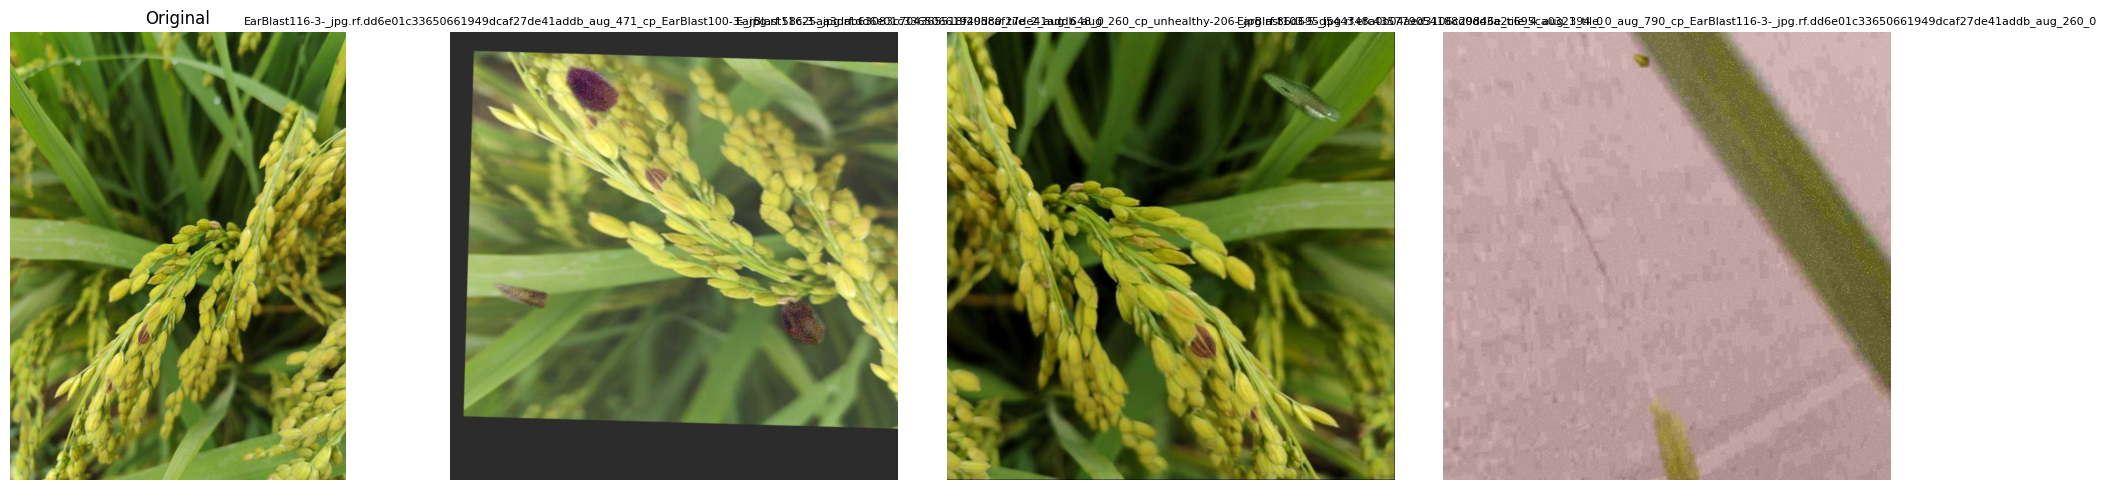

Gambar: EarBlast116-3-_jpg.rf.dd6e01c33650661949dcaf27de41addb.jpg
  - Ditemukan 13 augmentasi terkait.
--------------------------------------------------


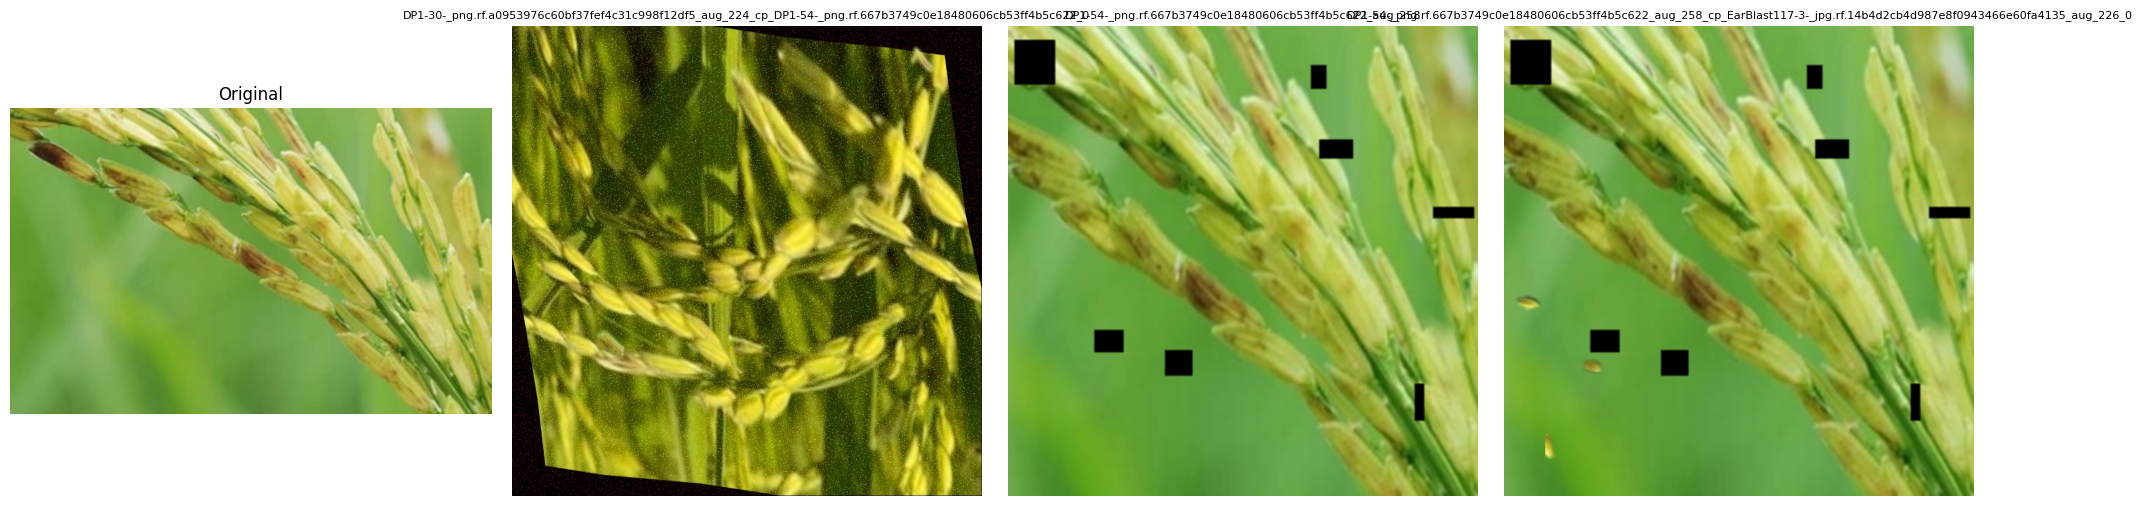

Gambar: DP1-54-_png.rf.667b3749c0e18480606cb53ff4b5c622.jpg
  - Ditemukan 6 augmentasi terkait.
--------------------------------------------------


In [53]:
# Tampilkan visualisasi hasil augmentasi
visualize_augmentations(TRAIN_IMAGES_PATH, num_samples=2)

In [54]:
!du -sh /content/datasets

1.1G	/content/datasets


# Train, Val, and Predict

## Training

Adjust class weight before training using inverse frequency method

In [55]:
import os
import yaml
from collections import Counter

# Path ke file data.yaml Anda
data_yaml_path = f"{dataset.location}/data.yaml"

# Muat file data.yaml
with open(data_yaml_path, 'r') as f:
    data_yaml = yaml.safe_load(f)

# Path ke direktori label pelatihan
train_labels_dir = os.path.join(dataset.location, 'train', 'labels')

# Hitung frekuensi setiap kelas
class_counts = Counter()

if not os.path.exists(train_labels_dir):
    print(f"❌ Error: Training labels directory not found at {train_labels_dir}")
else:
    for label_file in os.listdir(train_labels_dir):
        if label_file.endswith('.txt'):
            with open(os.path.join(train_labels_dir, label_file), 'r') as f:
                for line in f:
                    line = line.strip()
                    if line:  # pastikan tidak kosong
                        class_id = int(line.split()[0])
                        class_counts[class_id] += 1

    # Hitung inverse frequency
    num_classes = len(data_yaml.get('names', []))
    inverse_frequencies = [0.0] * num_classes
    for class_id, count in class_counts.items():
        if class_id < num_classes:
            inverse_frequencies[class_id] = 1.0 / count if count > 0 else 0.0

    # Normalisasi dengan skala bobot terkecil = 1
    positive_weights = [w for w in inverse_frequencies if w > 0]
    min_weight = min(positive_weights) if positive_weights else 1.0
    class_weights = [round(w / min_weight, 4) if w > 0 else 0.0 for w in inverse_frequencies]

    # Tambahkan bobot kelas ke data.yaml
    data_yaml['weights'] = class_weights

    # Simpan kembali file data.yaml
    with open(data_yaml_path, 'w') as f:
        yaml.safe_dump(data_yaml, f, sort_keys=False)

    print(f"✅ Bobot kelas (skala terkecil=1) telah ditambahkan ke {data_yaml_path}\n")
    print(f"📊 Bobot Kelas (Min=1): {class_weights}")

    # Tampilkan isi file data.yaml setelah modifikasi
    print("\n📄 Isi data.yaml setelah update:")
    with open(data_yaml_path, 'r') as f:
        print(f.read())


✅ Bobot kelas (skala terkecil=1) telah ditambahkan ke /content/datasets/Rice-Grain-21/data.yaml

📊 Bobot Kelas (Min=1): [2.0454, 1.0]

📄 Isi data.yaml setelah update:
train: ../train/images
val: ../valid/images
test: ../test/images
nc: 2
names:
- brown_spot
- bulir_sehat
roboflow:
  workspace: tbe
  project: rice-grain-svjri
  version: 21
  license: CC BY 4.0
  url: https://universe.roboflow.com/tbe/rice-grain-svjri/dataset/21
weights:
- 2.0454
- 1.0



In [61]:
train_hyp = dict(
    task="segment",
    data=f"{dataset.location}/data.yaml",
    epochs=2500,
    imgsz=1024,
    plots=True,
    hsv_h=0.0,
    hsv_s=0.5,
    hsv_v=0.4,
    degrees=180,
    translate=0.1,
    scale=0.3,
    shear=1,
    perspective=0.00001,
    flipud=0.25,
    fliplr=0.25,
    bgr=0.0,
    mosaic=0.5,
    mixup=0.0,
    cutmix=0.5,
    copy_paste=0.5,
    copy_paste_mode="mixup",

    lr0=0.01047,
    lrf=0.0075,
    momentum=0.80434,
    weight_decay=0.00102,
    box=9.0594,
    cls=0.48542,
    dfl=2.62724,
    warmup_epochs=2.55604,
    warmup_momentum=0.87073,
    close_mosaic=11
)

In [57]:
%cd {HOME}

/content


### Mini-Training (Optional)

In [59]:
from ultralytics import YOLO
import shutil, time
from copy import deepcopy

model = YOLO("yolo11m-seg.pt")

# Make a copy of the original training hyperparameters
mini_train_hyp = deepcopy(train_hyp)

# Override specific parameters for mini training
mini_train_hyp['epochs'] = 30
mini_train_hyp['imgsz'] = 640
mini_train_hyp['batch'] = 16
mini_train_hyp['name'] = 'mini_train'

# Train with modified hyperparameters
model.train(**mini_train_hyp)

Ultralytics 8.3.206 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=-1, bgr=0.0, box=9.0594, cache=False, cfg=None, classes=None, close_mosaic=11, cls=0.48542, compile=False, conf=None, copy_paste=0.3, copy_paste_mode=mixup, cos_lr=False, cutmix=0.3, data=/content/datasets/Rice-Grain-21/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=2.62724, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.0, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.0, hsv_s=0.0, hsv_v=0.0, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01047, lrf=0.0075, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11m-seg.pt, momentum=0.80434, mosaic=0.4, multi_scale=False, name=mini_train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=

ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7de1b8fc3f20>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.04104

### Full Training

In [ ]:
from ultralytics import YOLO
import shutil, time

model = YOLO("yolo11m-seg.pt")

# Cache last best file seen
last_best = {"path": None, "mtime": None}

def save_best(trainer):
    best_path = trainer.best
    if best_path and os.path.exists(best_path):
        mtime = os.path.getmtime(best_path)
        if best_path != last_best["path"] or mtime != last_best["mtime"]:
            # Update cache
            last_best["path"] = best_path
            last_best["mtime"] = mtime

            # Fixed destination folder (always overwrite)
            dst = f"/content/drive/MyDrive/{RUNS_FOLDER_NAME}/checkpoints"
            shutil.copytree("/content/runs", dst, dirs_exist_ok=True)

            # Grab training details
            best_fitness = getattr(trainer, "best_fitness", None)
            loss_names   = getattr(trainer, "loss_names", None)
            metrics      = getattr(trainer, "metrics", None)
            total_loss   = getattr(trainer, "tloss", None)

            # Print summary
            print("✅ runs folder uploaded →", dst)
            print("\nModel details:")
            print(f"  Best fitness: {best_fitness}")
            print(f"  Total loss: {total_loss}")
            print(f"  Loss names: {loss_names}\n")

            print("  Metrics:")
            if isinstance(metrics, dict):
                for key, value in metrics.items():
                    print(f"    {key}: {value}")
            elif isinstance(metrics, (list, tuple)):
                for i, value in enumerate(metrics):
                    print(f"    [{i}] {value}")
            else:
                print(f"    {metrics}")


# Register callback
model.add_callback("on_fit_epoch_end", save_best)

# Train
model.train(**train_hyp)

Ultralytics 8.3.206 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=9.0594, cache=False, cfg=None, classes=None, close_mosaic=11, cls=0.48542, compile=False, conf=None, copy_paste=0.5, copy_paste_mode=mixup, cos_lr=False, cutmix=0.5, data=/content/datasets/Rice-Grain-21/data.yaml, degrees=180, deterministic=True, device=None, dfl=2.62724, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=2500, erasing=0.4, exist_ok=False, fliplr=0.25, flipud=0.25, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.0, hsv_s=0.5, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01047, lrf=0.0075, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11m-seg.pt, momentum=0.80434, mosaic=0.5, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10

**NOTE:** The results of the completed training are saved in `{HOME}/runs/detect/train/`. Let's examine them.

In [ ]:
!ls {HOME}/runs/segment/train/

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/segment/train/confusion_matrix.png', width=1000)

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/segment/train/results.png', width=1400)

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/segment/train/val_batch0_pred.jpg', width=1400)

## Validate fine-tuned model

In [ ]:
model = YOLO(f"{HOME}/runs/segment/train/weights/best.pt")  # load a custom model

# Validate the model
metrics = model.val(
    task="segment",
    data=f"{dataset.location}/data.yaml",
    imgsz=640,
    max_det=1000,
    plots=False,
    visualize=True
)

In [ ]:
metrics = model.val(
    task="segment",
    data=f"{dataset.location}/data.yaml",
    imgsz=640,
    max_det=1000,
    plots=True,
    visualize=False
)

In [ ]:
metrics.box.map  # map50-95

In [ ]:
metrics.box.map50  # map50

In [ ]:
metrics.box.map75  # map75

In [ ]:
metrics.box.maps  # a list contains map50-95 of each category

In [ ]:
# !yolo task=segment mode=val model={HOME}/runs/segment/train/weights/best.pt data={dataset.location}/data.yaml imgsz=640 plots=True max_det=1000

## Inference with custom model

In [ ]:
model = YOLO(f"{HOME}/runs/segment/train/weights/best.pt")  # load a custom model

In [ ]:
model.predict(
    task="segment",
    source=f"{dataset.location}/test/images",
    imgsz=640,
    conf=0.5,
    iou=0.5,
    max_det=1000,
    visualize=True,
    save=True,
    show_labels=False,
    show_conf=False
)

In [ ]:
# !yolo task=segment mode=predict model={HOME}/runs/segment/train/weights/best.pt imgsz=640 source={dataset.location}/test/images save=True conf=0.5 iou=0.5 max_det=1000 visualize=True show=True save=True

**NOTE:** Let's take a look at few results.

In [ ]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob(f'{HOME}/runs/segment/predict*/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:3]:
    display(IPyImage(filename=img, width=600))
    print("\n")

In [ ]:
!ls runs/segment/predict

In [ ]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob(f'{HOME}/runs/segment/predict/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[17:18]:
    print(img)
    display(IPyImage(filename=img, width=600))
    print("\n")

In [ ]:
# # ls /content/runs/segment/predict/flare_0014_jpg.rf.dc43f1770f6dd479c527fb2f05bfc849.jpg
# !ls /content/datasets/Fire-and-Smoke-Segmentation-1/test/images/flare_0014_jpg.rf.dc43f1770f6dd479c527fb2f05bfc849.jpg

In [ ]:
from ultralytics import YOLO
from PIL import Image
import requests

model = YOLO(f'{HOME}/runs/segment/train/weights/best.pt')
image = Image.open(f"/content/datasets/Rice-Grain-{VERSION}/test/images/EarBlast104-3-_jpg.rf.a21e421cf85a705dd6139fa76ee05e62.jpg")
result = model.predict(image, conf=0.5)[0]

In [ ]:
import supervision as sv

detections = sv.Detections.from_ultralytics(result)

In [ ]:
mask_annotator = sv.MaskAnnotator()

annotated_image = image.copy()
mask_annotator.annotate(annotated_image, detections=detections)

sv.plot_image(annotated_image, size=(10, 10))

## Upload Final Results to Drive

In [ ]:
def save_full_runs():
    src = "/content/runs"
    dst = f"/content/drive/MyDrive/{RUNS_FOLDER_NAME}/final_results"
    shutil.copytree(src, dst, dirs_exist_ok=True)
    print(f"📦 Full training runs copied to: {dst}")

In [ ]:
save_full_runs()

In [ ]:
import shutil, glob, os

# === Destination folder in Drive ===
dst_dir = f"/content/drive/MyDrive/{RUNS_FOLDER_NAME}"
os.makedirs(dst_dir, exist_ok=True)

# === Find the current notebook in /content ===
notebooks = glob.glob("/content/*.ipynb")

if notebooks:
    notebook_path = notebooks[0]  # usually just one notebook
    dst_path = os.path.join(dst_dir, os.path.basename(notebook_path))

    shutil.copy2(notebook_path, dst_path)
    print(f"📘 Notebook saved (overwritten if existed): {dst_path}")
else:
    print("⚠️ No notebook found in /content to upload.")


In [ ]:
# Catat waktu selesai
end_time = time.time()

# Hitung total waktu berjalan dalam detik
elapsed_time = end_time - start_time

# Konversi detik ke jam, menit, dan detik
hours = int(elapsed_time // 3600)
minutes = int((elapsed_time % 3600) // 60)
seconds = int(elapsed_time % 60)

print(f"\n🎉 Script Selesai!")
print(f"Total Waktu Berjalan: {hours} jam, {minutes} menit, {seconds} detik.")

# 🏆 Congratulations

### Learning Resources

Roboflow has produced many resources that you may find interesting as you advance your knowledge of computer vision:

- [Roboflow Notebooks](https://github.com/roboflow/notebooks): A repository of over 20 notebooks that walk through how to train custom models with a range of model types, from YOLOv7 to SegFormer.
- [Roboflow YouTube](https://www.youtube.com/c/Roboflow): Our library of videos featuring deep dives into the latest in computer vision, detailed tutorials that accompany our notebooks, and more.
- [Roboflow Discuss](https://discuss.roboflow.com/): Have a question about how to do something on Roboflow? Ask your question on our discussion forum.
- [Roboflow Models](https://roboflow.com): Learn about state-of-the-art models and their performance. Find links and tutorials to guide your learning.

### Convert data formats

Roboflow provides free utilities to convert data between dozens of popular computer vision formats. Check out [Roboflow Formats](https://roboflow.com/formats) to find tutorials on how to convert data between formats in a few clicks.

### Connect computer vision to your project logic

[Roboflow Templates](https://roboflow.com/templates) is a public gallery of code snippets that you can use to connect computer vision to your project logic. Code snippets range from sending emails after inference to measuring object distance between detections.